In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math

from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu

sns.set_style("whitegrid")

### Read in samples for origin ARS313, to set up the annotation of the nucleosome areas

## Wildtype

In [86]:
load_dir =  "ARS313"

In [87]:
wt_rep3 = np.loadtxt(load_dir + "/wt_mat_Megalodon_repIII_ARS313_end_LexA.txt")

#replicate 2
wt_rep2 = np.loadtxt(load_dir + "/mat_Megalodon_repII_ARS313_end_LexA.txt")

In [88]:
#feature annotation
#anno = pd.read_csv(load_dir + "/Features from ARS313_end_LexA  (31 .. 1076).txt", sep  = "\t", 
#                          header = None, index_col = 0)
#anno.columns = ["position", "length"]

#anno = pd.read_csv(load_dir + "/coordinates_ARS313.txt", sep  = "\t", 
#                          header = None, index_col = 0)

#Third version of annotation
anno = pd.read_csv(load_dir + "/ARS313_80bp.txt", sep  = "\t", 
                          header = None, index_col = 0)

#Fourth annotation
#anno = pd.read_csv(load_dir + "/coordinates_ARS313_v4.csv", sep  = ",", 
#                          header = None, index_col = 0)
anno.columns = ["position"]

anno.index = anno.index.astype("string")
anno.index = anno.index.str.strip()

#anno["pos_start"] = anno.position.str.split(".").str[0].astype(int) -1
#anno["pos_stop"] = anno.position.str.split(".").str[2].astype(int) -1

anno["pos_start"] = anno.position.str.split("-").str[0].astype(int) -1
anno["pos_stop"] = anno.position.str.split("-").str[1].astype(int) -1

anno["length"] = anno.pos_stop - anno.pos_start

In [89]:
#Load methylation data for the reverse strand:

wt_rep3_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_repIII_ARS313_end_LexA.txt")
wt_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_repII_ARS313_end_LexA.txt")

dies6_rep1_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220126_METHYLATION_DIES6_ALL_REP1_ARS313_end_LexA.txt")
dies6_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220207_DIES6_ALLstrains_meth_REP2_ARS313_end_LexA.txt")

disw2_rep1_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20211201_all_strains_REP1_disw2_ARS313_end_LexA.txt")
disw2_rep2_rev = np.loadtxt(load_dir + "/reverse/mat_Megalodon_20220221_disw2_all_meth_REP2_ARS313_end_LexA.txt")

In [90]:
print(wt_rep2.shape[1] == wt_rep3.shape[1])
print(wt_rep3_rev.shape[0] == wt_rep3.shape[0])
print(wt_rep2.shape, wt_rep2_rev.shape)

True
True
(493, 1033) (492, 1036)


In [91]:
def subsample(array, n):
    np.random.seed(15)
    idx = np.random.randint(len(array), size=n)
    return array[idx,:]

wt_rep3_join = np.concatenate((wt_rep3, wt_rep3_rev[:, :-3]), axis = 0)
#subsample wt_rep2_rev to 780 reads
wt_rep2_sub = subsample(wt_rep2, 492)
wt_rep2_join = np.concatenate((wt_rep2_sub, wt_rep2_rev[:, :-3]), axis = 0)

wt_rep3 = wt_rep3_join
wt_rep2 = wt_rep2_join

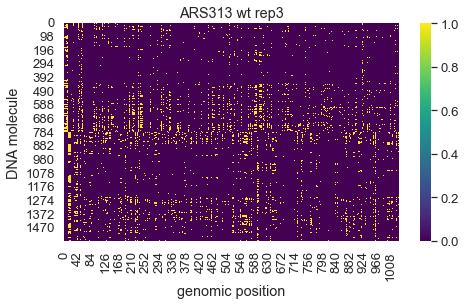

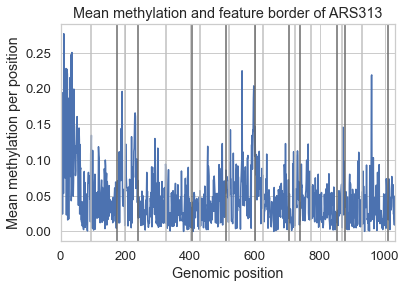

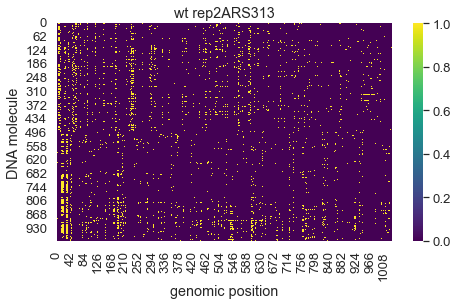

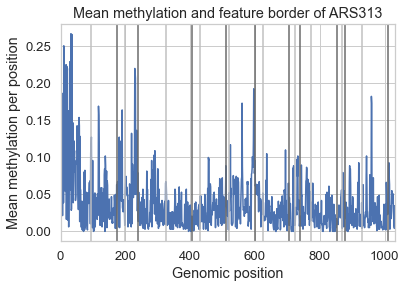

In [92]:
#plot the raw data:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + " wt rep3")
plt.show()

#and the bulk data:
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep3.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title("Mean methylation and feature border of " + load_dir)
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

#wildtype replicate 2:
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title("wt rep2" + load_dir)
plt.show()

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = wt_rep2.mean(axis = 0)
                )
plt.xlabel("Genomic position")
plt.ylabel("Mean methylation per position")
plt.title("Mean methylation and feature border of " + load_dir)
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

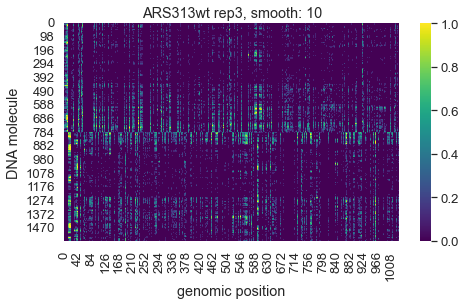

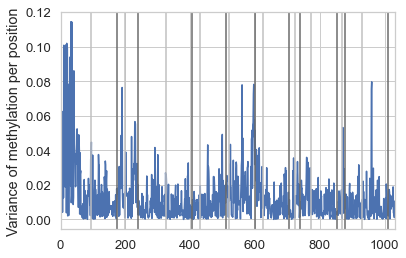

In [93]:
smooth_window = 10

def smooth(array):
        return np.convolve(array, np.ones(smooth_window)/smooth_window, mode = "same")
    
wt_rep3_smooth = np.apply_along_axis(smooth, 0, wt_rep3)
    
plt.figure(figsize=(7.5,4))
sns.heatmap(wt_rep3_smooth, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir + "wt rep3, smooth: " + str(smooth_window))
plt.show()

sns.lineplot(x = range(wt_rep3_smooth.shape[1]), 
                 y = wt_rep3_smooth.std(axis = 0)**2
                )
plt.ylabel("Variance of methylation per position")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

In [94]:
#sns.lineplot(x = wt_rep3.shape[1], y = 100 * wt_rep3.cumsum(axis = 0)wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1])

#wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :].shape
100 * wt_rep3.cumsum(axis = 0)[wt_rep3.shape[0] -1 , :]/wt_rep3.shape[1]

array([9.77734753, 2.80735721, 0.96805421, ..., 1.3552759 , 7.45401742,
       1.74249758])

<AxesSubplot:>

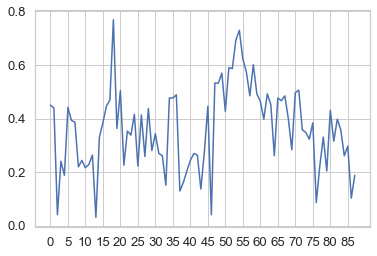

In [95]:
#this computes the percent of methylation at a specific base
wt_rep3.cumsum(axis = 0)/wt_rep3.shape[1]

#as a measure for the heterogeneity, try the entropy:
# alternatively, try: from scipy.stats import entropy

def entropy(labels, base=None):
    base = 2 if base is None else base
    _ ,counts = np.unique(labels, return_counts=True)
    norm_counts = counts / counts.sum()

    return -(norm_counts * np.log(norm_counts)/np.log(base)).sum()

#https://stackoverflow.com/questions/15450192/fastest-way-to-compute-entropy-in-python

#entropy(ARS305_wt[:,6])
#np.unique(ARS305_wt[:,6], return_counts = True)

g = sns.lineplot(x = range(630-542), y = np.apply_along_axis(entropy, 0, wt_rep3[:, 542:630]))
g.set_xticks(range(0, 630-542, 5))
g

<AxesSubplot:title={'center':'ARS313 wt rep3, entropy per position'}, ylabel='entropy'>

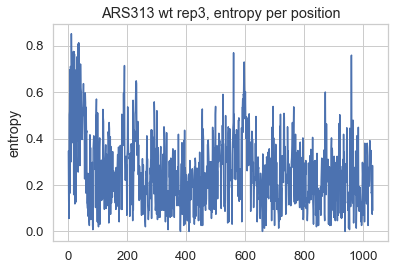

In [96]:
g = sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.apply_along_axis(entropy, 0, wt_rep3))
g.set_ylabel("entropy")
g.set_title(load_dir + " wt rep3, " + "entropy per position")
#g.set_xticks(range(0, ARS305_wt.shape[1], 50))
g

In [97]:
entropy_wt_rep3 = np.apply_along_axis(entropy, 0, wt_rep3)
entropy_wt_rep3.min(), entropy_wt_rep3.max(), np.count_nonzero(entropy_wt_rep3)

(-0.0, 0.851224335262138, 1029)

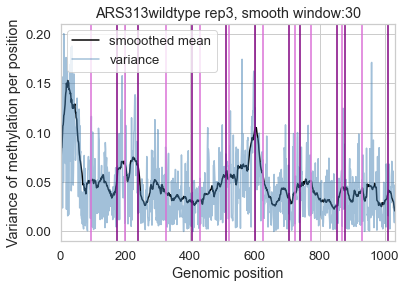

In [98]:
N = 30

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(N)/N, mode ="same"),
             color = "black", label = "smooothed mean")
#plt.ylabel("Mean methylation over sample")
plt.xlim(0, wt_rep3.shape[1])
plt.title(load_dir +  "wildtype rep3, smooth window:" + str(N))


sns.lineplot(x = range(wt_rep3.shape[1]), 
            y = wt_rep3.std(axis = 0)**2, color = "steelblue", alpha = 0.5,
            label = "variance"
            )
plt.ylabel("Variance of methylation per position")
plt.xlabel("Genomic position")
#plt.axvline(62, color = "purple", label = "border")
plt.xlim(0, wt_rep3.shape[1])
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "orchid")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "purple")

## Load data for mutant dies6

In [99]:
dies6_rep1 = np.loadtxt(load_dir + "/DIES6_ALL_REP1_ARS313_end_LexA.txt")
print(dies6_rep1.shape, dies6_rep1_rev.shape) 

dies6_rep2 = np.genfromtxt(load_dir + "/DIES6_ARS313_REP2_780READS.csv", dtype = int, delimiter = ",")
print(dies6_rep2.shape, dies6_rep2_rev.shape) 

(780, 1033) (780, 1036)
(780, 1033) (780, 1036)


In [100]:
#join the plus and minus strand
dies6_rep1_join = np.concatenate((dies6_rep1, dies6_rep1_rev[:, :-3]), axis = 0)
dies6_rep2_join = np.concatenate((dies6_rep2, dies6_rep2_rev[:, :-3]), axis = 0)

#rename joined samples to run the rest of the pipeline with it

dies6_rep1 = dies6_rep1_join.copy()
dies6_rep2 = dies6_rep2_join.copy()

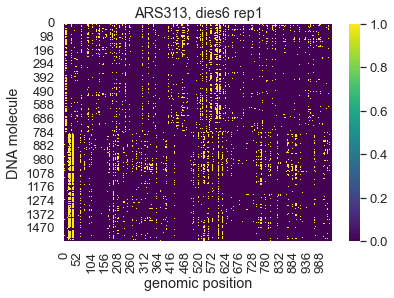

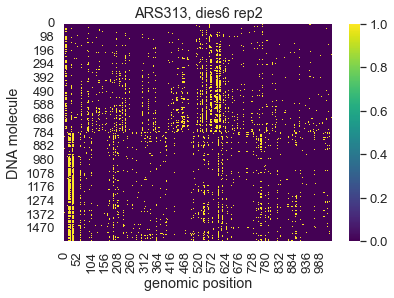

In [101]:
sns.heatmap(dies6_rep1, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep1.shape[1])
plt.title(load_dir + ", dies6 rep1")
plt.show()


sns.heatmap(dies6_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep2.shape[1])
plt.title(load_dir + ", dies6 rep2")
plt.show()

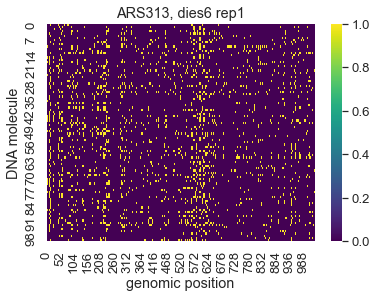

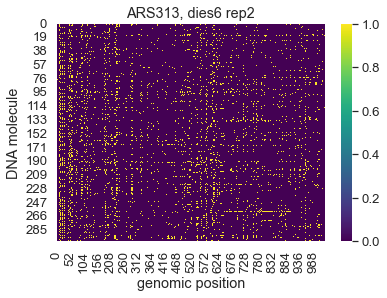

In [102]:
#subsample to the same number of molecules than in 316
#rep1 -> 83
#rep2 -> 301

#def subsample(df, n):
#    np.random.seed(0)
#    return df[np.random.RandomState(seed=24).choice(len(df), n)]

def subsample(array, n):
    np.random.seed(15)
    idx = np.random.randint(len(array), size=n)
    return array[idx,:]

test1 = subsample(dies6_rep1, 100)
test2 = subsample(dies6_rep2, 300)

sns.heatmap(test1, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep1.shape[1])
plt.title(load_dir + ", dies6 rep1")
plt.show()

sns.heatmap(test2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, dies6_rep2.shape[1])
plt.title(load_dir + ", dies6 rep2")
plt.show()

In [103]:
#subsample dies6 replicates to the same size as in 316, and oberserve the effect on differential
#methylation per feature in the below output

#dies6_rep1 = subsample(dies6_rep1, 83)
#dies6_rep2 = subsample(dies6_rep2, 301)

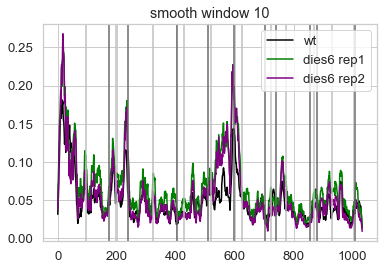

(21530.0, 2.5747333270307454e-144)

In [104]:
#smooth_window=1
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "dies6 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "dies6 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

wt_rep3_smooth_mean = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep1_smooth_mean = np.convolve(dies6_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
dies6_rep2_smooth_mean = np.convolve(dies6_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((wt_rep3_smooth_mean.reshape(1, wt_rep3.shape[1]), 
                        dies6_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        dies6_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                              axis = 0)

from scipy.stats import wilcoxon

w, p = wilcoxon(means[0,:], means[1,:], alternative = "two-sided")
w,p

In [105]:
#statistical test to compare replicates of the mutants: 
wilcoxon(dies6_rep1.mean(axis = 0), 
         dies6_rep2.mean(axis = 0), alternative = "two-sided")

WilcoxonResult(statistic=48827.5, pvalue=6.103394552215084e-108)

## Load data for mutant disw2

In [106]:
disw2_rep1 = np.genfromtxt(load_dir + "/ARS313_disw2_rep1_780READS_noNA.csv", dtype = int,
                                 delimiter = ",")
print(disw2_rep1.shape, disw2_rep1_rev.shape)

disw2_rep2 = np.genfromtxt(load_dir + "/ARS313_disw2_rep2_780READS_noNA.csv", dtype = int, delimiter = ",")
print(disw2_rep2.shape, disw2_rep2_rev.shape)

(780, 1033) (780, 1036)
(780, 1033) (780, 1036)


In [107]:
#join the plus and minus strand, no subsampling here

disw2_rep1_join = np.concatenate((disw2_rep1, disw2_rep1_rev[:, :-3]), axis = 0)
disw2_rep2_join = np.concatenate((disw2_rep2, disw2_rep2_rev[:, :-3]), axis = 0)

#rename joined samples to run the rest of the pipeline with it

disw2_rep1 = disw2_rep1_join.copy()
disw2_rep2 = disw2_rep2_join.copy()

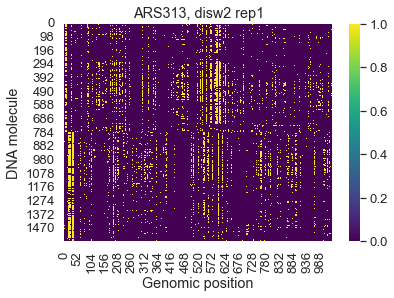

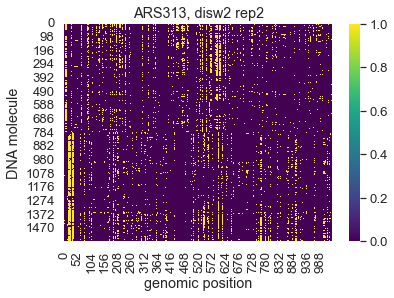

In [108]:
sns.heatmap(disw2_rep1, cmap = "viridis")
plt.xlabel("Genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep1.shape[1])
plt.title(load_dir + ", disw2 rep1")
plt.show()


sns.heatmap(disw2_rep2, cmap = "viridis")
plt.xlabel("genomic position")
plt.ylabel("DNA molecule")
plt.xlim(0, disw2_rep2.shape[1])
plt.title(load_dir + ", disw2 rep2")
plt.show()

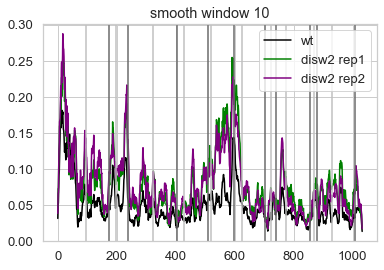

In [109]:
#smooth = 1

sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(wt_rep3.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "green", label = "disw2 rep1")
sns.lineplot(x = range(wt_rep3.shape[1]), 
                 y = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same"),
             color = "purple", label = "disw2 rep2")
plt.title("smooth window " + str(smooth_window))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

In [110]:
# calculate the mean over all molecules and smooth with window size "smooth"

disw2_rep1_smooth_mean = np.convolve(disw2_rep1.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")
disw2_rep2_smooth_mean = np.convolve(disw2_rep2.mean(axis = 0), np.ones(smooth_window)/smooth_window, mode ="same")

means = np.concatenate((means, 
                        disw2_rep1_smooth_mean.reshape(1, wt_rep3.shape[1]),
                        disw2_rep2_smooth_mean.reshape(1, wt_rep3.shape[1])),
                        axis = 0)

w, p = wilcoxon(disw2_rep1.mean(axis = 0),
                disw2_rep2.mean(axis = 0), alternative = "two-sided")
w,p

(254272.5, 0.8283481167836464)

In [111]:
#summarise samples
array_dic = {"wt_rep3": wt_rep3_join, 
             "wt_rep2": wt_rep2_join, 
             "dies6_rep1": dies6_rep1_join,
            "dies6_rep2": dies6_rep2_join,
            "disw2_rep1": disw2_rep1_join,
            "disw2_rep2": disw2_rep2_join}

summary=pd.DataFrame()
for element in array_dic.keys():
    summary[element] = pd.DataFrame(array_dic[element].mean(axis=0)).describe()
summary = summary.T
summary["#molecules"] = [array_dic[sample].shape[0] for sample in summary.index]
#summary = summary.T
summary

,count,mean,std,min,25%,50%,75%,max,#molecules
wt_rep3,1033.0,0.049472,0.042051,0.0,0.018590,0.040385,0.066026,0.276923,1560
wt_rep2,1033.0,0.038092,0.038645,0.0,0.012195,0.026423,0.049797,0.266260,984
dies6_rep1,1033.0,0.068616,0.070726,0.0,0.014103,0.050641,0.093590,0.418590,1560
dies6_rep2,1033.0,0.056691,0.066784,0.0,0.012179,0.037179,0.071795,0.428205,1560
disw2_rep1,1033.0,0.080577,0.079684,0.0,0.014744,0.060256,0.117949,0.416667,1560
disw2_rep2,1033.0,0.079953,0.077885,0.0,0.020513,0.057051,0.112821,0.435256,1560


### Min-max normalise each experiment and pool replicates

In [112]:
"""wt_rep3_minmax = wt_rep3.mean(axis = 0)/wt_rep3.mean(axis = 0).max()
wt_rep2_minmax = wt_rep2.mean(axis = 0)/wt_rep2.mean(axis = 0).max()

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1.mean(axis = 0)/dies6_rep1.mean(axis = 0).max()
dies6_rep2_minmax = dies6_rep2.mean(axis = 0)/dies6_rep2.mean(axis = 0).max()

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1.mean(axis = 0)/disw2_rep1.mean(axis = 0).max()
disw2_rep2_minmax = disw2_rep2.mean(axis = 0)/disw2_rep2.mean(axis = 0).max()

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)"""

'wt_rep3_minmax = wt_rep3.mean(axis = 0)/wt_rep3.mean(axis = 0).max()\nwt_rep2_minmax = wt_rep2.mean(axis = 0)/wt_rep2.mean(axis = 0).max()\n\npooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)\n\n#dies6\ndies6_rep1_minmax = dies6_rep1.mean(axis = 0)/dies6_rep1.mean(axis = 0).max()\ndies6_rep2_minmax = dies6_rep2.mean(axis = 0)/dies6_rep2.mean(axis = 0).max()\n\npooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)\n\n#disw2\ndisw2_rep1_minmax = disw2_rep1.mean(axis = 0)/disw2_rep1.mean(axis = 0).max()\ndisw2_rep2_minmax = disw2_rep2.mean(axis = 0)/disw2_rep2.mean(axis = 0).max()\n\npooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)'

In [113]:
#normalization to the mean frequency of methylation of the same origin:

"""wt_rep3_minmax = wt_rep3.mean(axis = 0)/wt_rep3.flatten().mean(axis = 0)
wt_rep2_minmax = wt_rep2.mean(axis = 0)/wt_rep2.flatten().mean(axis = 0)

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1.mean(axis = 0)/dies6_rep1.flatten().mean(axis = 0)
dies6_rep2_minmax = dies6_rep2.mean(axis = 0)/dies6_rep2.flatten().mean(axis = 0)

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1.mean(axis = 0)/disw2_rep1.flatten().mean(axis = 0)
disw2_rep2_minmax = disw2_rep2.mean(axis = 0)/disw2_rep2.flatten().mean(axis = 0)

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)"""

#normalise to the nucleosomal array spike-ins
mean_array_wt_rep3 = 0.048283
mean_array_wt_rep2 = 0.034160
mean_array_dies6_rep1=0.050732
mean_array_dies6_rep2 = 0.045048
mean_array_disw2_rep1 = 0.061350
mean_array_disw2_rep2 = 0.059359

wt_rep3_minmax = wt_rep3.mean(axis = 0)/mean_array_wt_rep3
wt_rep2_minmax = wt_rep2.mean(axis = 0)/mean_array_wt_rep2

pooled_wt = np.concatenate((wt_rep3_minmax.reshape(1, -1), wt_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#dies6
dies6_rep1_minmax = dies6_rep1.mean(axis = 0)/mean_array_dies6_rep1
dies6_rep2_minmax = dies6_rep2.mean(axis = 0)/mean_array_dies6_rep2

pooled_dies6 = np.concatenate((dies6_rep1_minmax.reshape(1, -1), dies6_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)

#disw2
disw2_rep1_minmax = disw2_rep1.mean(axis = 0)/mean_array_disw2_rep1
disw2_rep2_minmax = disw2_rep2.mean(axis = 0)/mean_array_disw2_rep2

pooled_disw2 = np.concatenate((disw2_rep1_minmax.reshape(1, -1), disw2_rep2_minmax.reshape(1,-1)), axis = 0).mean(axis = 0)




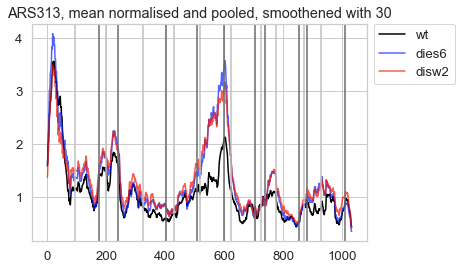

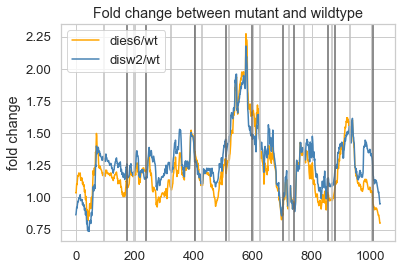

In [114]:
N=30

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_wt, np.ones(N)/N, mode="same"), #wt_min_max
             color = "black", 
            label = "wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same"), #dies6_min_max
             color = "#0a22fa", alpha = 0.7,
            label = "dies6")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
            y = np.convolve(pooled_disw2, np.ones(N)/N, mode = "same"), #disw2_min_max
            color = "#f2180c", alpha = 0.7,
            label = "disw2")
plt.title(load_dir +  ", mean normalised and pooled, smoothened with " + str(N)) #pooled and min-max normalised
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.show()

sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "orange", 
             label = "dies6/wt")
sns.lineplot(x = range(wt_rep3_minmax.shape[0]),
             y = np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
            color = "steelblue",
             label = "disw2/wt")
plt.ylabel("fold change")
plt.title("Fold change between mutant and wildtype")
for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
plt.show()

### Compare mean distributions between pooled replicates and pooled wildtype with paired wilcoxon test

In [115]:
segments = anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [pooled_dies6[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["dies6_mean"] = pd.Series(array_list, index = segments.index)

#disw2 mutant

array_list = [pooled_disw2[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["disw2_mean"] = pd.Series(array_list, index = segments.index)

In [116]:
segments["p_value_dies6"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean"],
                                                alternative = "less").pvalue for index in segments.index]

segments["p_value_disw2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean"],
                                                alternative = "less").pvalue for index in segments.index]
segments.drop(segments.columns[3:6], axis =1, inplace = True)

In [117]:
segments
#segments.to_csv(load_dir + "/ARS313_pooled_samples_two-sided-test.csv")

,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
0,,,,,
+3ns,94,174,80,6.892304e-04,5.704061e-06
+2L,199,239,40,4.929596e-03,4.382932e-03
+2ns,324,404,80,1.668533e-04,4.543197e-05
+1ns,429,509,80,9.266380e-04,1.150047e-04
ARS313,519,599,80,2.679178e-08,2.904210e-08
-1ns,624,704,80,3.528767e-02,1.194010e-02
-1L,724,739,15,5.980225e-01,5.980225e-01
-2ns,774,854,80,4.211407e-02,2.226166e-03
-2L,869,879,10,4.228516e-01,2.158203e-01


In [118]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the dies6 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_dies6"] < pvalue)]

       Which sites have a different mean methylation in the dies6 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
0,,,,,
+3ns,94,174,80,6.892304e-04,5.704061e-06
+2L,199,239,40,4.929596e-03,4.382932e-03
+2ns,324,404,80,1.668533e-04,4.543197e-05
+1ns,429,509,80,9.266380e-04,1.150047e-04
ARS313,519,599,80,2.679178e-08,2.904210e-08
-3ns,929,1009,80,8.452871e-06,1.361899e-07


In [119]:
#Regions significant for disw2:
print("       Which sites have a different mean methylation in the disw2 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_disw2"] < pvalue)]

       Which sites have a different mean methylation in the disw2 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6,p_value_disw2
0,,,,,
+3ns,94,174,80,6.892304e-04,5.704061e-06
+2L,199,239,40,4.929596e-03,4.382932e-03
+2ns,324,404,80,1.668533e-04,4.543197e-05
+1ns,429,509,80,9.266380e-04,1.150047e-04
ARS313,519,599,80,2.679178e-08,2.904210e-08
-1ns,624,704,80,3.528767e-02,1.194010e-02
-2ns,774,854,80,4.211407e-02,2.226166e-03
-3ns,929,1009,80,8.452871e-06,1.361899e-07


### Compare pooled wildtype to mutant replicates, then filter regions

In [120]:
segments = anno.drop(columns = "position")

#list comprehension to catch the pooled methylation values per sample in a cell per column
array_list = [pooled_wt[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]

segments["wt_mean"] = pd.Series(array_list, index = segments.index)

#dies6 mutant 
array_list = [dies6_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [dies6_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["dies6_mean_rep2"] = pd.Series(array_list, index = segments.index)


#disw2 mutant
array_list = [disw2_rep1_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep1"] = pd.Series(array_list, index = segments.index)

array_list = [disw2_rep2_minmax[segments.loc[index, "pos_start"]:segments.loc[index, "pos_stop"]] for 
 index in segments.index]
segments["disw2_mean_rep2"] = pd.Series(array_list, index = segments.index)

In [121]:
#perform statistical test
segments["p_value_dies6_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_dies6_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"dies6_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]

segments["p_value_disw2_rep1"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep1"],
                                                alternative = "two-sided").pvalue for index in segments.index]
segments["p_value_disw2_rep2"] = [wilcoxon(segments.loc[index, "wt_mean"], 
                                                segments.loc[index,"disw2_mean_rep2"],
                                                alternative = "two-sided").pvalue for index in segments.index]
test_higher = segments.iloc[:, :8]
segments.drop(segments.columns[3:8], axis =1, inplace = True)

In [122]:
#segments.to_csv(load_dir + "/ARS313_separate_replicates_two-sided-test.csv")
segments

,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
+3ns,94,174,80,3.788548e-05,1.091645e-01,4.727867e-03,7.615477e-07
+2L,199,239,40,5.177305e-03,3.721468e-02,5.129684e-02,1.584719e-03
+2ns,324,404,80,3.788451e-05,9.597730e-03,2.526365e-04,2.595283e-05
+1ns,429,509,80,3.788548e-05,3.207921e-01,5.093951e-03,1.023330e-04
ARS313,519,599,80,1.070762e-07,5.358356e-08,1.466387e-07,2.177570e-08
-1ns,624,704,80,2.052517e-02,2.536551e-01,2.541276e-02,5.689377e-02
-1L,724,739,15,1.000000e+00,7.197266e-01,9.779663e-01,9.779663e-01
-2ns,774,854,80,1.563489e-02,5.488156e-01,1.473064e-03,1.543004e-02
-2L,869,879,10,4.316406e-01,2.753906e-01,2.753906e-01,9.218750e-01


In [123]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the dies6 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_dies6_rep1"] < pvalue) &
            (segments["p_value_dies6_rep2"] < pvalue)]

       Which sites have a different mean methylation in the dies6 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
+2ns,324,404,80,3.788451e-05,9.597730e-03,2.526365e-04,2.595283e-05
ARS313,519,599,80,1.070762e-07,5.358356e-08,1.466387e-07,2.177570e-08


In [124]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a different mean methylation in the disw2 mutant?")
print("       P-value below: ", pvalue)
segments.loc[(segments["p_value_disw2_rep1"] < pvalue) &
            (segments["p_value_disw2_rep2"] < pvalue)]

       Which sites have a different mean methylation in the disw2 mutant?
       P-value below:  0.025


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
+3ns,94,174,80,3.788548e-05,1.091645e-01,4.727867e-03,7.615477e-07
+2ns,324,404,80,3.788451e-05,9.597730e-03,2.526365e-04,2.595283e-05
+1ns,429,509,80,3.788548e-05,3.207921e-01,5.093951e-03,1.023330e-04
ARS313,519,599,80,1.070762e-07,5.358356e-08,1.466387e-07,2.177570e-08
-2ns,774,854,80,1.563489e-02,5.488156e-01,1.473064e-03,1.543004e-02
-3ns,929,1009,80,1.758984e-07,4.039689e-01,4.086592e-07,4.518778e-07


In [125]:
#Repeat this test for the case that methylation in one fragment is higher than in wildtype:

test_higher["p_value_dies6_rep1"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"dies6_mean_rep1"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_dies6_rep2"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"dies6_mean_rep2"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep1"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"disw2_mean_rep1"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher["p_value_disw2_rep2"] = [wilcoxon(test_higher.loc[index, "wt_mean"], 
                                           test_higher.loc[index,"disw2_mean_rep2"],
                                                alternative = "less").pvalue for index in test_higher.index]

test_higher.drop(test_higher.columns[3:8], axis =1, inplace = True)

In [126]:
test_higher

,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
+3ns,94,174,80,1.894274e-05,5.458224e-02,2.363934e-03,3.807739e-07
+2L,199,239,40,2.588653e-03,1.860734e-02,2.564842e-02,7.923594e-04
+2ns,324,404,80,1.894225e-05,4.798865e-03,1.263182e-04,1.297641e-05
+1ns,429,509,80,1.894274e-05,1.603961e-01,2.546976e-03,5.116650e-05
ARS313,519,599,80,5.353811e-08,2.679178e-08,7.331937e-08,1.088785e-08
-1ns,624,704,80,1.026258e-02,1.268276e-01,1.270638e-02,2.844689e-02
-1L,724,739,15,5.110168e-01,6.606140e-01,5.329590e-01,5.329590e-01
-2ns,774,854,80,7.817445e-03,2.744078e-01,7.365318e-04,7.715020e-03
-2L,869,879,10,2.158203e-01,8.837891e-01,1.376953e-01,4.609375e-01


In [127]:
#Regions significant for dies6:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the dies6 mutant?")
test_higher.loc[(test_higher["p_value_dies6_rep1"] < pvalue) & 
         (test_higher["p_value_dies6_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the dies6 mutant?


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
+2L,199,239,40,2.588653e-03,1.860734e-02,2.564842e-02,7.923594e-04
+2ns,324,404,80,1.894225e-05,4.798865e-03,1.263182e-04,1.297641e-05
ARS313,519,599,80,5.353811e-08,2.679178e-08,7.331937e-08,1.088785e-08


In [128]:
#Regions significant for disw2:
pvalue = 2.5e-2

print("       Which sites have a higher mean methylation for the disw2 mutant?")
test_higher.loc[(test_higher["p_value_disw2_rep1"] < pvalue) & 
         (test_higher["p_value_disw2_rep2"] < pvalue)]

       Which sites have a higher mean methylation for the disw2 mutant?


,pos_start,pos_stop,length,p_value_dies6_rep1,p_value_dies6_rep2,p_value_disw2_rep1,p_value_disw2_rep2
0,,,,,,,
+3ns,94,174,80,1.894274e-05,5.458224e-02,2.363934e-03,3.807739e-07
+2ns,324,404,80,1.894225e-05,4.798865e-03,1.263182e-04,1.297641e-05
+1ns,429,509,80,1.894274e-05,1.603961e-01,2.546976e-03,5.116650e-05
ARS313,519,599,80,5.353811e-08,2.679178e-08,7.331937e-08,1.088785e-08
-2ns,774,854,80,7.817445e-03,2.744078e-01,7.365318e-04,7.715020e-03
-3ns,929,1009,80,8.794918e-08,2.019844e-01,2.043296e-07,2.259389e-07


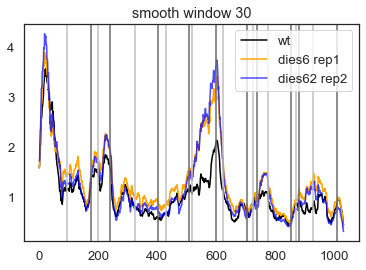

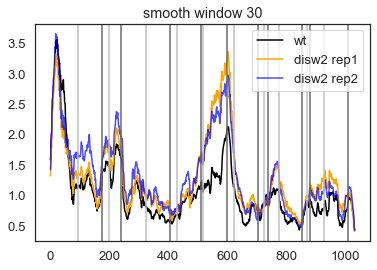

In [129]:
# How does that look over the whole sequence?
sns.set_style("white")
smooth_width = 30

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "orange", label = "dies6 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "blue", alpha = 0.7, label = "dies62 rep2")
plt.title("smooth window " + str(smooth_width))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "black", label = "wt")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "orange", label = "disw2 rep1")
sns.lineplot(x = range(pooled_wt.shape[0]), 
                 y = np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
             color = "blue", alpha = 0.7, label = "disw2 rep2")
plt.title("smooth window " + str(smooth_width))

for border in anno.loc[:, "pos_start"]:
    plt.axvline(border, color = "silver")
for border in anno.loc[:, "pos_stop"]:
    plt.axvline(border, color = "dimgray")
    
plt.show()

In [130]:
#Display the mean methylation per feature

def condense_features(array, anno):
    output = np.empty(array.shape[0],)
    for index in anno.index:
        feature_array = array[:, anno.loc[index, "pos_start"]: anno.loc[index, "pos_stop"]]
        means_by_feature = np.apply_along_axis(np.mean, 1, feature_array)
        output = np.column_stack((output, means_by_feature))
    return output[:, 1:]

def max_normalise_array(array):
    return array/array.mean(axis=0).max()

In [131]:
"""#normalize the count matrices to the max of averages of the respective sample
wt_rep3_maxnorm = max_normalise_array(wt_rep3)
wt_rep2_maxnorm = max_normalise_array(wt_rep2)

dies6_rep1_maxnorm = max_normalise_array(dies6_rep1)
dies6_rep2_maxnorm = max_normalise_array(dies6_rep2)

disw2_rep1_maxnorm = max_normalise_array(disw2_rep1)
disw2_rep2_maxnorm = max_normalise_array(disw2_rep2)
"""

#normalise the count matrices to the mean methylation frequency of the nucleosomal array spike-in controls
#normalise to the nucleosomal array spike-ins

wt_rep3_maxnorm = wt_rep3/mean_array_wt_rep3
wt_rep2_maxnorm = wt_rep2/mean_array_wt_rep2

dies6_rep1_maxnorm = dies6_rep1/mean_array_dies6_rep1
dies6_rep2_maxnorm = dies6_rep2/mean_array_dies6_rep2

disw2_rep1_maxnorm = disw2_rep1/mean_array_disw2_rep1
disw2_rep2_maxnorm = disw2_rep2/mean_array_disw2_rep2

#condense methylation by feature 
wt_rep3_feat_me = condense_features(wt_rep3_maxnorm, anno)
wt_rep2_feat_me = condense_features(wt_rep2_maxnorm, anno)

wt_pool = np.concatenate((wt_rep3_feat_me, wt_rep2_feat_me), axis = 0)

dies6_rep1_feat_me = condense_features(dies6_rep1_maxnorm, anno)
dies6_rep2_feat_me = condense_features(dies6_rep2_maxnorm, anno)

dies6_pool = np.concatenate((dies6_rep1_feat_me, dies6_rep2_feat_me), axis= 0)

disw2_rep1_feat_me = condense_features(disw2_rep1_maxnorm, anno)
disw2_rep2_feat_me = condense_features(disw2_rep2_maxnorm, anno)

disw2_pool = np.concatenate((disw2_rep1_feat_me, disw2_rep2_feat_me), axis = 0)

Comparing replicates


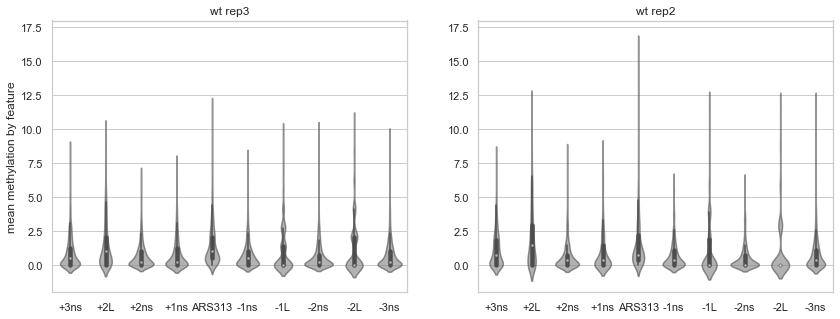

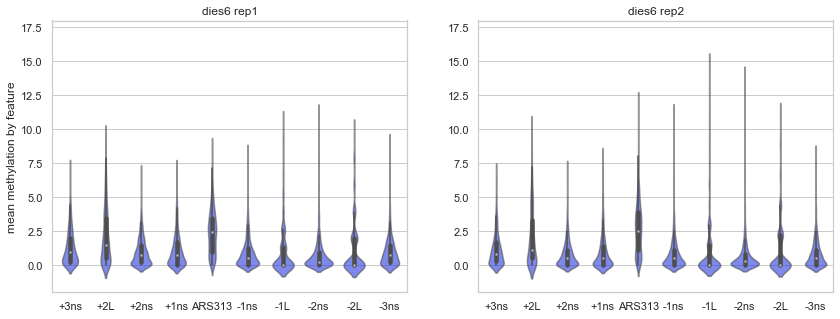

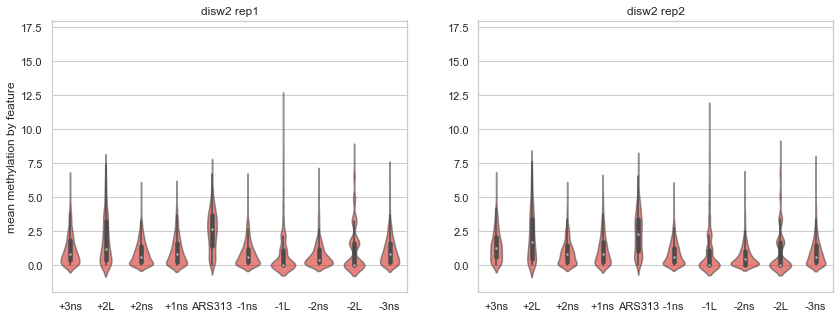

In [133]:
sns.set(font_scale=1)
sns.set_style("whitegrid")

print("Comparing replicates")
#wt
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))

sns.violinplot(data = wt_rep3_feat_me, axis = 1, color = "grey", ax=ax1)
ax1.set_title("wt rep3")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-2,18)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = wt_rep2_feat_me, axis = 1, color = "grey", ax=ax2)
ax2.set_title("wt rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-2,18)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS313_methylation_by_feature_wt_anno4.tif")
plt.show()

#dies6
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = dies6_rep1_feat_me, axis = 1, color = "#0a22fa", ax=ax1)
ax1.set_title("dies6 rep1")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-2,18)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = dies6_rep2_feat_me, axis = 1, color = "#0a22fa", ax=ax2)
ax2.set_title("dies6 rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-2,18)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS313_methylation_by_feature_dies6_anno4.tif")
plt.show()

#disw2
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14,5))
sns.violinplot(data = disw2_rep1_feat_me, axis = 1, color = "#f2180c", ax=ax1)
ax1.set_title("disw2 rep1")
ax1.set_xticklabels(anno.index)
ax1.set_ylim(-2,18)
ax1.set_ylabel("mean methylation by feature")
plt.setp(ax1.collections, alpha = 0.6)

sns.violinplot(data = disw2_rep2_feat_me, axis = 1, color = "#f2180c", ax=ax2)
ax2.set_title("disw2 rep2")
ax2.set_xticklabels(anno.index)
ax2.set_ylim(-2,18)
plt.setp(ax2.collections, alpha = 0.6)
#plt.savefig(load_dir + "/plots/ARS313_methylation_by_feature_disw2_anno4.tif")
plt.show()

In [209]:
#Combine the violinplots into one plot per replicate:
#for each feature, plot wt and mutants next to each other

#transfer array to dataframe, melt that into the long form and assign a catergory "condition"
feat_me_wt_rep3 = pd.DataFrame(wt_rep3_feat_me, columns = anno.index)
feat_me_wt_rep3["molecule"] = feat_me_wt_rep3.index
feat_me_wt_rep3_melt = pd.melt(feat_me_wt_rep3, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_rep3_melt["condition"] = "wt rep3"

feat_me_wt_rep2 = pd.DataFrame(wt_rep2_feat_me, columns = anno.index)
feat_me_wt_rep2["molecule"] = feat_me_wt_rep2.index
feat_me_wt_rep2_melt = pd.melt(feat_me_wt_rep2, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_rep2_melt["condition"] = "wt rep2"

feat_me_wt_pool = pd.DataFrame(wt_pool, columns = anno.index)
feat_me_wt_pool["molecule"] = feat_me_wt_pool.index
feat_me_wt_melt = pd.melt(feat_me_wt_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_wt_melt["condition"] = "wt"


#the same for dies6
feat_me_dies6_rep2 = pd.DataFrame(dies6_rep2_feat_me, columns = anno.index)
feat_me_dies6_rep2["molecule"] = feat_me_dies6_rep2.index

feat_me_dies6_rep2_melt = pd.melt(feat_me_dies6_rep2, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_rep2_melt["condition"] = "dies6"

feat_me_dies6_pool = pd.DataFrame(dies6_pool, columns = anno.index)
feat_me_dies6_pool["molecule"] = feat_me_dies6_pool.index
feat_me_dies6_melt = pd.melt(feat_me_dies6_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_dies6_melt["condition"] = "dies6"

#the same for disw2
feat_me_disw2_rep1 = pd.DataFrame(disw2_rep1_feat_me, columns = anno.index)
feat_me_disw2_rep1["molecule"] = feat_me_disw2_rep1.index

feat_me_disw2_rep1_melt = pd.melt(feat_me_disw2_rep1, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_rep1_melt["condition"] = "disw2"

feat_me_disw2_pool = pd.DataFrame(disw2_pool, columns = anno.index)
feat_me_disw2_pool["molecule"] = feat_me_disw2_pool.index
feat_me_disw2_melt = pd.melt(feat_me_disw2_pool, id_vars=("molecule"), var_name = ("feature"))
feat_me_disw2_melt["condition"] = "disw2"

#merge into one dataframe:
methylation_rep1 = pd.concat([feat_me_wt_melt, feat_me_dies6_melt, feat_me_disw2_melt])
methylation_rep1.rename(columns = {"value" : "norm methylation"}, inplace=True)

In [210]:
methylation_rep1.feature = pd.Categorical(methylation_rep1['feature'],
                                   categories=["-3ns", "-2L", "-2ns", "-1L", "-1ns", "ARS313", "+1ns",
                                              "+2ns", "+2L", "+3ns"],
                                   ordered=True)

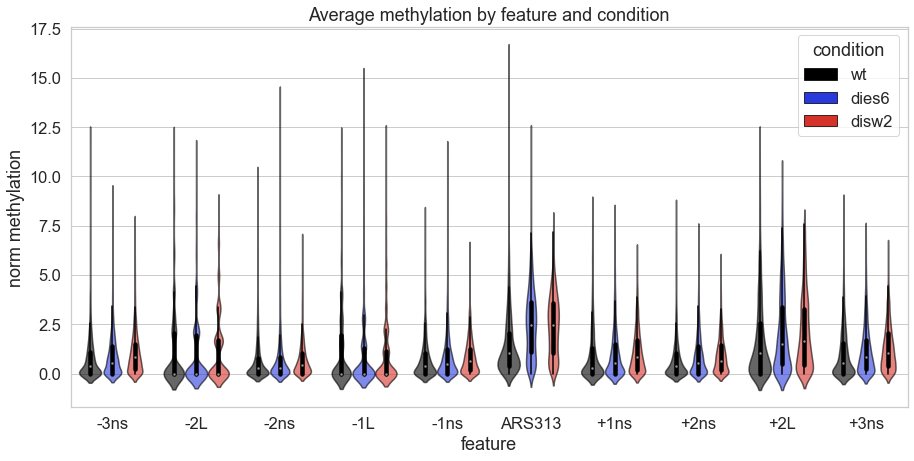

In [212]:
col_Anna = ["black", "#0a22fa", "#f2180c"]

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

plt.figure(figsize = (15,7))
ax = sns.violinplot(data = methylation_rep1, x="feature", y = "norm methylation", hue = "condition", 
                    palette = col_Anna)
plt.setp(ax.collections, alpha = 0.6)
plt.title("Average methylation by feature and condition")
#plt.savefig(load_dir + "/plots/ARS313_pooled_norm_av_methylation_by_feature_anno4.svg", dpi = 300)
plt.show()

In [138]:
#methylation_rep1.to_csv(load_dir + "/ARS313_violinplots_annotation_v3.csv")

In [187]:
#Combine the violinplots into one plot per replicate:
#for each feature, plot wt and mutants next to each other

#transfer array to dataframe, melt that into the long form and assign a catergory "condition"
feat_me_wt_rep3 = pd.DataFrame(wt_rep3_feat_me, columns = anno.index)
feat_me_wt_rep3["molecule"] = feat_me_wt_rep3.index
feat_me_wt_rep3["strand"] = ["plus" if i<feat_me_wt_rep3.shape[0]//2 else "minus" for i in range(feat_me_wt_rep3.shape[0])]
feat_me_wt_rep3_melt = pd.melt(feat_me_wt_rep3, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_wt_rep3_melt["condition"] = "wt"
feat_me_wt_rep3_melt["replicate"] = "wt rep3"

feat_me_wt_rep2 = pd.DataFrame(wt_rep2_feat_me, columns = anno.index)
feat_me_wt_rep2["molecule"] = feat_me_wt_rep2.index
feat_me_wt_rep2["strand"] = ["plus" if i<feat_me_wt_rep2.shape[0]//2 else "minus" for i in range(feat_me_wt_rep2.shape[0])]
feat_me_wt_rep2_melt = pd.melt(feat_me_wt_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_wt_rep2_melt["condition"] = "wt"
feat_me_wt_rep2_melt["replicate"] = "wt rep2"

#the same for dies6
feat_me_dies6_rep2 = pd.DataFrame(dies6_rep2_feat_me, columns = anno.index)
feat_me_dies6_rep2["molecule"] = feat_me_dies6_rep2.index
feat_me_dies6_rep2["strand"] = ["plus" if i<feat_me_dies6_rep2.shape[0]//2 else "minus" for i in range(feat_me_dies6_rep2.shape[0])]
feat_me_dies6_rep2_melt = pd.melt(feat_me_dies6_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_dies6_rep2_melt["condition"] = "dies6"
feat_me_dies6_rep2_melt["replicate"] = "dies6 rep2"

feat_me_dies6_rep1 = pd.DataFrame(dies6_rep1_feat_me, columns = anno.index)
feat_me_dies6_rep1["molecule"] = feat_me_dies6_rep1.index
feat_me_dies6_rep1["strand"] = ["plus" if i<feat_me_dies6_rep1.shape[0]//2 else "minus" for i in range(feat_me_dies6_rep1.shape[0])]
feat_me_dies6_rep1_melt = pd.melt(feat_me_dies6_rep1, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_dies6_rep1_melt["condition"] = "dies6"
feat_me_dies6_rep1_melt["replicate"] = "dies6 rep1"


#the same for disw2
feat_me_disw2_rep2 = pd.DataFrame(disw2_rep2_feat_me, columns = anno.index)
feat_me_disw2_rep2["molecule"] = feat_me_disw2_rep2.index
feat_me_disw2_rep2["strand"] = ["plus" if i<feat_me_disw2_rep2.shape[0]//2 else "minus" for i in range(feat_me_disw2_rep2.shape[0])]
feat_me_disw2_rep2_melt = pd.melt(feat_me_disw2_rep2, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_disw2_rep2_melt["condition"] = "disw2"
feat_me_disw2_rep2_melt["replicate"] = "disw2 rep2"

feat_me_disw2_rep1 = pd.DataFrame(disw2_rep1_feat_me, columns = anno.index)
feat_me_disw2_rep1["molecule"] = feat_me_disw2_rep1.index
feat_me_disw2_rep1["strand"] = ["plus" if i<feat_me_disw2_rep1.shape[0]//2 else "minus" for i in range(feat_me_disw2_rep1.shape[0])]
feat_me_disw2_rep1_melt = pd.melt(feat_me_disw2_rep1, id_vars=(["molecule", "strand"]), var_name = ("feature"))
feat_me_disw2_rep1_melt["condition"] = "disw2"
feat_me_disw2_rep1_melt["replicate"] = "disw2 rep1"

#merge into one dataframe:
methylation_features = pd.concat([feat_me_wt_rep3_melt, feat_me_wt_rep2_melt, 
                                  feat_me_dies6_rep1_melt, feat_me_dies6_rep2_melt,
                                  feat_me_disw2_rep1_melt, feat_me_disw2_rep2_melt
                                 ])
methylation_features.rename(columns = {"value" : "norm_methylation"}, inplace=True)

In [184]:
#methylation_features.to_csv(load_dir + "/ARS313_feature_methylation_annotation_v3.csv")

1.1740740203332636
0.0 16.10070257611241
0.6112469437652811 3.2599837000814995


<AxesSubplot:ylabel='norm_methylation'>

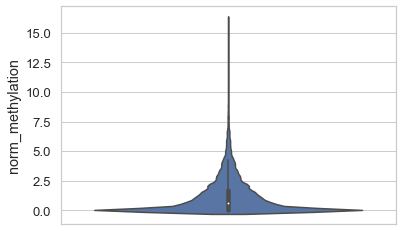

In [202]:
print(methylation_features.norm_methylation.mean())
print(methylation_features.norm_methylation.min(), methylation_features.norm_methylation.max())
print(methylation_features.norm_methylation.quantile(0.50), methylation_features.norm_methylation.quantile(0.90))
sns.violinplot(data = methylation_features, y = "norm_methylation")

In [192]:
"""test = wt_rep3_feata_me
test2 = dies6_rep1_feat_me

from scipy.stats import mannwhitneyu

scipy.stats.mannwhitneyu(test[:, 7],
             test2[:, 7], alternative = "two-sided").pvalue

for number in range(10):
    np.random.shuffle(test[:, 7])
    np.random.shuffle(test2[:, 7])
    print(scipy.stats.mannwhitneyu(test[:, 7],
             test2[:, 7], alternative = "two-sided").pvalue)
 """

'test = wt_rep3_feata_me\ntest2 = dies6_rep1_feat_me\n\nfrom scipy.stats import mannwhitneyu\n\nscipy.stats.mannwhitneyu(test[:, 7],\n             test2[:, 7], alternative = "two-sided").pvalue\n\nfor number in range(10):\n    np.random.shuffle(test[:, 7])\n    np.random.shuffle(test2[:, 7])\n    print(scipy.stats.mannwhitneyu(test[:, 7],\n             test2[:, 7], alternative = "two-sided").pvalue)\n '

In [140]:
from scipy.stats import mannwhitneyu

#Calculate p-values for the distributions in the violins using the mann-whitney U test

feature_pvalues = anno.drop(columns = "position")
feature_pvalues["wt_rep3"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_wt_rep3.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]
feature_pvalues["wt_rep2"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_wt_rep2.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]
feature_pvalues["dies6_rep2"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_rep2.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]
feature_pvalues["disw2_rep1"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_rep1.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]

feature_pvalues

,pos_start,pos_stop,length,wt_rep3,wt_rep2,dies6_rep2,disw2_rep1
0,,,,,,,
+3ns,94,174,80,0.029126,0.003088,4.516689e-10,2.964191e-14
+2L,199,239,40,0.040852,0.005506,2.851874e-11,1.485052e-11
+2ns,324,404,80,0.089348,0.020118,3.254236e-11,2.097369e-30
+1ns,429,509,80,0.606917,0.481935,7.840975e-05,1.654534e-29
ARS313,519,599,80,0.630659,0.513802,1.418625e-107,7.292769e-121
-1ns,624,704,80,0.098649,0.023986,1.284239e-03,1.068676e-16
-1L,724,739,15,0.099947,0.021715,1.006602e-05,4.441435e-01
-2ns,774,854,80,0.031180,0.003023,5.084764e-03,1.101962e-30
-2L,869,879,10,0.001849,0.000009,1.639310e-01,4.076909e-09


In [141]:
feature_pvalues[feature_pvalues.wt_rep3 < 2.5e-2]

#from scipy.stats import ttest_ind
#[ttest_ind(feat_me_wt_pool.loc[:, column], feat_me_wt_rep3.loc[:, column], 
#           alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]

,pos_start,pos_stop,length,wt_rep3,wt_rep2,dies6_rep2,disw2_rep1
0,,,,,,,
-2L,869,879,10,0.001849,0.000009,0.163931,4.076909e-09


In [142]:
#for number in range(20):
#    test1 = np.random.randint(0, 100, 20)
#    test2 = np.random.randint(0, 100, 20)
#    print(mannwhitneyu(test1, test2, alternative = "two-sided").pvalue)


In [143]:
feature_pvalues[feature_pvalues.dies6_rep2 < 2.5e-2]

,pos_start,pos_stop,length,wt_rep3,wt_rep2,dies6_rep2,disw2_rep1
0,,,,,,,
+3ns,94,174,80,0.029126,0.003088,4.516689e-10,2.964191e-14
+2L,199,239,40,0.040852,0.005506,2.851874e-11,1.485052e-11
+2ns,324,404,80,0.089348,0.020118,3.254236e-11,2.097369e-30
+1ns,429,509,80,0.606917,0.481935,7.840975e-05,1.654534e-29
ARS313,519,599,80,0.630659,0.513802,1.418625e-107,7.292769e-121
-1ns,624,704,80,0.098649,0.023986,1.284239e-03,1.068676e-16
-1L,724,739,15,0.099947,0.021715,1.006602e-05,4.441435e-01
-2ns,774,854,80,0.031180,0.003023,5.084764e-03,1.101962e-30
-3ns,929,1009,80,0.764643,0.682980,2.931493e-06,5.364556e-45


In [144]:
feature_pvalues[feature_pvalues.disw2_rep1 < 2.5e-2]

,pos_start,pos_stop,length,wt_rep3,wt_rep2,dies6_rep2,disw2_rep1
0,,,,,,,
+3ns,94,174,80,0.029126,0.003088,4.516689e-10,2.964191e-14
+2L,199,239,40,0.040852,0.005506,2.851874e-11,1.485052e-11
+2ns,324,404,80,0.089348,0.020118,3.254236e-11,2.097369e-30
+1ns,429,509,80,0.606917,0.481935,7.840975e-05,1.654534e-29
ARS313,519,599,80,0.630659,0.513802,1.418625e-107,7.292769e-121
-1ns,624,704,80,0.098649,0.023986,1.284239e-03,1.068676e-16
-2ns,774,854,80,0.031180,0.003023,5.084764e-03,1.101962e-30
-2L,869,879,10,0.001849,0.000009,1.639310e-01,4.076909e-09
-3ns,929,1009,80,0.764643,0.682980,2.931493e-06,5.364556e-45


In [145]:
#Calculate p-values for the distributions in the violins using the mann-whitney U test

feature_pvalues = anno.drop(columns = "position")
feature_pvalues["dies6_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_dies6_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]
feature_pvalues["disw2_pool"] = [mannwhitneyu(feat_me_wt_pool.loc[:, column],
                                        feat_me_disw2_pool.loc[:, column], 
                                        alternative = "two-sided").pvalue for column in feat_me_wt_rep3.columns if not column == "molecule"]

feature_pvalues

,pos_start,pos_stop,length,dies6_pool,disw2_pool
0,,,,,
+3ns,94,174,80,2.754448e-18,3.374736e-45
+2L,199,239,40,1.409097e-15,2.157497e-26
+2ns,324,404,80,2.368807e-23,1.791454e-46
+1ns,429,509,80,2.748246e-14,2.693095e-47
ARS313,519,599,80,2.729531e-145,2.414816e-146
-1ns,624,704,80,2.828523e-06,2.198749e-23
-1L,724,739,15,6.667261e-05,8.080804e-01
-2ns,774,854,80,1.441652e-05,2.664148e-29
-2L,869,879,10,1.009713e-01,4.605035e-05


In [146]:
feature_pvalues[feature_pvalues.dies6_pool < 2.5e-2]

,pos_start,pos_stop,length,dies6_pool,disw2_pool
0,,,,,
+3ns,94,174,80,2.754448e-18,3.374736e-45
+2L,199,239,40,1.409097e-15,2.157497e-26
+2ns,324,404,80,2.368807e-23,1.791454e-46
+1ns,429,509,80,2.748246e-14,2.693095e-47
ARS313,519,599,80,2.729531e-145,2.414816e-146
-1ns,624,704,80,2.828523e-06,2.198749e-23
-1L,724,739,15,6.667261e-05,8.080804e-01
-2ns,774,854,80,1.441652e-05,2.664148e-29
-3ns,929,1009,80,1.765981e-16,1.325698e-44


In [147]:
feature_pvalues[feature_pvalues.disw2_pool < 2.5e-2]

,pos_start,pos_stop,length,dies6_pool,disw2_pool
0,,,,,
+3ns,94,174,80,2.754448e-18,3.374736e-45
+2L,199,239,40,1.409097e-15,2.157497e-26
+2ns,324,404,80,2.368807e-23,1.791454e-46
+1ns,429,509,80,2.748246e-14,2.693095e-47
ARS313,519,599,80,2.729531e-145,2.414816e-146
-1ns,624,704,80,2.828523e-06,2.198749e-23
-2ns,774,854,80,1.441652e-05,2.664148e-29
-2L,869,879,10,1.009713e-01,4.605035e-05
-3ns,929,1009,80,1.765981e-16,1.325698e-44


In [148]:
#feature_pvalues.to_csv(load_dir + "/ARS313_p_values_avg_feature_methylation.csv")

## How sparse can we expect the signal to be in the annotated features?

In [149]:
seq="ATGAAAGAATACGTTATTCTTTCATCAAATCGTGGTCGACCGGCATGCAAGCTCCGAAAGATTGGGAGTTGGTAGACCTTTTGGTCGTTAATGAAATTGAGGGTCTTCAAATCGTGGAAAGTGTATTTGATAATGAACTTGTTGAAGAAATAAGGGAGAAGATAAAGGACGACTTTTTAGGAGAATATCGTAAAATTTGTGAGCTTTTGTATGAAAAACTCATGAATCGAAAGAAAAGAGGAATTGTGGTTATGACTTTGGGTTCGAGAGGGGTGCTTTTCTGTTCGCACGAAAGCCCTGAAGTACAATTCCTTCCGGCTATTCAAAATGTTTCGGTTGTTGATACTACAGGAGCTGGAGATACTTTCCTGGGCGGTTTGGTTACTCAATTGTATCAAGGAGAGACCTTGTCTACGGCTATAAAGTTCTCTACATTAGCTAGTTCATTGACCATTCAAAGAAAAGGTGCTGCTGAAAGCATGCCACTGTATAAAGATGTTCAGAAAGATGCATAAAATCTACTGCAATTTTTTACTTTTAGTTTGTTAAATTTTAGTTTTCGTCATATATATAAAGTTTAAAAAGGTACAAAGAATGCAGTAATAAGAAATGTAATTACATGAGGGCAGTTTAAGTGCTACCTTTTAAGACGGAAGAACTAATACCATAACCGAGAGTAATTACGCAGACAAACGCTAACAACGAAGCAGGAACACCTCTGGAGATAAAAGCGCCTACAGTTAGCCATCTATTACCCTTTTTATCGGTCATAGAAATAGCAGTAACGTTTGGAAATCCAGATGAAGCCAACCCCATACCGCATGAGGCTAACAAGGCGCAACCGAACACAAGAATTGGAGCTGCCTTTGGATCGGATAATTTGTCACCAACTTCTTGCACCAAGGGAATAATGATGATTGCTGACACAGTATGTGAGACAAAAGTGCCCACAACTAACATTAAAATACCGAAAATACATAAGATAGCAAAAACACCATCGTTCTGAATTTTCTTTTGTAATGCTCTTGCAATA"
seq = seq.lower()
seq_char = anno.drop(columns = "position")

array_list = [seq[seq_char.loc[index, "pos_start"]:seq_char.loc[index, "pos_stop"]] for 
 index in seq_char.index]

seq_char["sequence"] = pd.Series(array_list, index = seq_char.index)

seq_char["a_percent"] = [row.count("a")/len(row)*100 for row in seq_char["sequence"]]
seq_char["t_percent"] = [row.count("t")/len(row)*100 for row in seq_char["sequence"]]
seq_char["cg_percent"] = [row.count("cg")/len(row)*100 for row in seq_char["sequence"]]
seq_char["gc_percent"] = [row.count("gc")/len(row)*100 for row in seq_char["sequence"]]
seq_char["gc_content"] = [(row.count("c")+row.count("g"))/len(row)*100 for row in seq_char["sequence"]]
seq_char.drop(columns = "sequence", inplace=True)

seq_char

,pos_start,pos_stop,length,a_percent,t_percent,cg_percent,gc_percent,gc_content
0,,,,,,,,
+3ns,94,174,80,38.750000,26.250000,2.500000,0.000000,35.00
+2L,199,239,40,45.000000,25.000000,2.500000,2.500000,30.00
+2ns,324,404,80,25.000000,32.500000,2.500000,2.500000,42.50
+1ns,429,509,80,36.250000,26.250000,0.000000,6.250000,37.50
ARS313,519,599,80,35.000000,43.750000,1.250000,2.500000,21.25
-1ns,624,704,80,38.750000,20.000000,6.250000,5.000000,41.25
-1L,724,739,15,46.666667,13.333333,6.666667,13.333333,40.00
-2ns,774,854,80,40.000000,12.500000,5.000000,7.500000,47.50
-2L,869,879,10,40.000000,20.000000,10.000000,0.000000,40.00


## Plot the methylation frequency for the whole sequence of the origin:

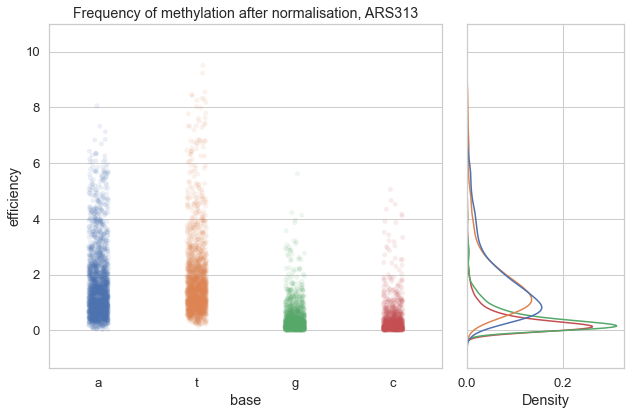

In [150]:
#prepare the data:
#eff_df = pd.DataFrame({"wt_rep3": wt_rep3.mean(axis=0)}, index=range(1033))
eff_df = pd.DataFrame({"wt_rep3": wt_rep3_minmax}, index=range(1033))

eff_df["base"] = [letter for letter in seq]
#eff_df["wt_rep2"] = wt_rep2.mean(axis=0)
#eff_df["dies6_rep1"] = dies6_rep1.mean(axis=0)
#eff_df["dies6_rep2"] = dies6_rep2.mean(axis=0)
#eff_df["disw2_rep1"] = disw2_rep1.mean(axis=0)
#eff_df["disw2_rep2"] = disw2_rep2.mean(axis=0)

eff_df["wt_rep2"] = wt_rep2_minmax
eff_df["dies6_rep1"] = dies6_rep1_minmax
eff_df["dies6_rep2"] = dies6_rep2_minmax
eff_df["disw2_rep1"] = disw2_rep1_minmax
eff_df["disw2_rep2"] = disw2_rep2_minmax

eff_df_melt = eff_df.melt(id_vars="base", var_name= "sample", value_name="efficiency")

# specify plot layouts with different width using subplots()
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

f, axs = plt.subplots(1,2,
                      figsize=(9,6),
                      sharey=True,
                     gridspec_kw=dict(width_ratios=[2.5,1]))
# make scatterplot with legends
sns.stripplot(data = eff_df_melt, x = "base", y = "efficiency", alpha=0.1, ax= axs[0])
axs[0].set_title("Frequency of methylation after normalisation, ARS313")
axs
# make densityplot with kdeplot without legends
sns.kdeplot(data= eff_df_melt,
                y="efficiency",
                hue="base",
                ax=axs[1],
                legend=False, warn_singular=False)
f.tight_layout()
#plt.savefig(load_dir + "/plots/methylation_efficiency_ARS313.tif", dpi=300)

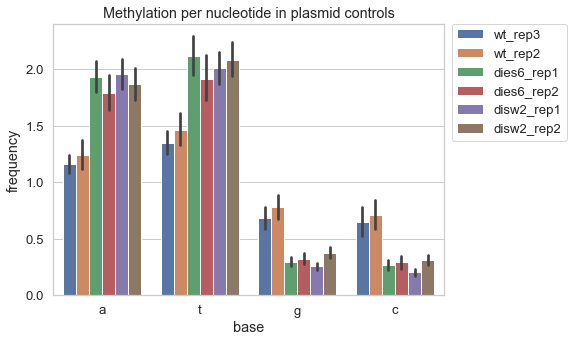

In [151]:
plt.figure(figsize=(7,5))
sns.barplot(data=eff_df_melt, x = "base", y = "efficiency", hue = "sample")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.title("Methylation per nucleotide in plasmid controls")
plt.ylabel("frequency")
#plt.savefig(load_dir + "/plots/methylation_efficiency_naked_plasmid_per_sample.tif", dpi=300, bbox_inches='tight')
plt.show()

<AxesSubplot:title={'center':'Normalized methylation over samples'}, xlabel='sample', ylabel='normalized frequency of methylation'>

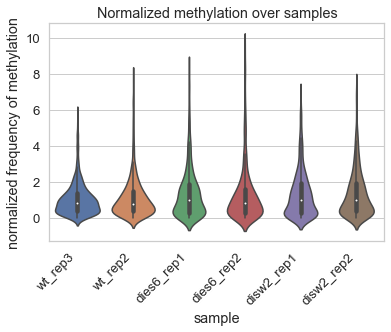

In [152]:
g = sns.violinplot(data = eff_df_melt, x = "sample", y = "efficiency", alpha=0.1)
g.set_ylabel("normalized frequency of methylation")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title("Normalized methylation over samples")

g

In [153]:
#Exporting aggregated data for Anna to plot for the manuscript 
#31th May 2022

smooth = {"wt_pooled": np.convolve(pooled_wt, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep3": np.convolve(wt_rep3_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
          "wt_rep2": np.convolve(wt_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep1": np.convolve(dies6_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_rep2": np.convolve(dies6_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "dies6_pooled": np.convolve(pooled_dies6, np.ones(smooth_width)/smooth_width, mode="same"),
         "disw2_rep1": np.convolve(disw2_rep1_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_rep2": np.convolve(disw2_rep2_minmax, np.ones(smooth_width)/smooth_width, mode ="same"),
         "disw2_pooled": np.convolve(pooled_disw2, np.ones(smooth_width)/smooth_width, mode="same")}


ARS313_smooth_30 = pd.DataFrame.from_dict(smooth)
ARS313_smooth_30.index = ARS313_smooth_30.index + 1
#ARS313_smooth_30.to_csv("ARS313/ARS313_smoothed_average_methylation_winsize_30.csv")

FC = {
    "dies6_pooled" : np.convolve(pooled_dies6, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same"),
    "disw2_pooled" : np.convolve(pooled_disw2, np.ones(N)/N, mode="same")/np.convolve(pooled_wt, np.ones(N)/N, mode="same")
}

ARS313_FCs = pd.DataFrame.from_dict(FC)
ARS313_FCs.index = ARS313_FCs.index + 1

#ARS313_FCs.to_csv("ARS313/ARS313_smoothed_fold_changes_winsize_30.csv")